# Detecção de Fake News - BERT

O objetivo deste projeto é aplicar técnicas de Deep Learning para desenvolver um modelo robusto capaz de classificar textos jornalísticos em língua inglesa como verdadeiros ou falsos (fake news).

Para o treinamento e avaliação do modelo, foi utilizada a base de dados [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data), um recurso amplamente utilizado na comunidade acadêmica e de pesquisa para esta finalidade.

#### **1. Arquitetura do Modelo e Estratégia de Fine-Tuning**

O modelo base utilizado foi o `bert-base-uncased`, uma arquitetura Transformer pré-treinada e amplamente reconhecida por sua eficácia em tarefas de Processamento de Linguagem Natural (PLN). Para adaptar este modelo à tarefa de classificação, foi adicionada uma camada linear no topo, utilizando a classe `AutoModelForSequenceClassification` da biblioteca Hugging Face.

A estratégia de fine-tuning adotada consistiu em congelar todos os parâmetros do modelo base, com exceção das camadas finais de pooling. Essas camadas são responsáveis por agregar as informações contextuais da sequência em um único vetor de representação. Dessa forma, o treinamento ajustou apenas os pesos dessa seção final, permitindo uma adaptação eficiente e computacionalmente otimizada para a tarefa específica, sem alterar o conhecimento linguístico geral do BERT.

#### **2. Metodologia**

**2.1. Preparação dos Dados**

Para garantir a compatibilidade com o ecossistema da Hugging Face, os DataFrames contendo os dados de treino, validação e teste foram convertidos para o formato Dataset. Em seguida, foi aplicado um processo de tokenização utilizando o tokenizer específico do `bert-base-uncased`. Esse processo converte os textos em sequências de tokens numéricos, que servem como entrada para o modelo.

**2.2. Otimização de Hiperparâmetros**

A busca pela configuração ideal de hiperparâmetros foi automatizada com o uso do framework Optuna. O objetivo do processo de otimização foi minimizar a função de perda (loss function) no conjunto de validação. Foram exploradas diferentes combinações para os seguintes hiperparâmetros:

* Taxa de aprendizado (Learning rate)

* Tamanho do lote (Batch size)

* Decaimento de peso (Weight decay)

**2.3. Treinamento do Modelo**

Utilizando os hiperparâmetros otimizados na etapa anterior, o modelo foi treinado em um processo monitorado pela técnica de parada antecipada (early stopping). Foi definida uma paciência de 4 épocas, o que significa que o treinamento seria interrompido se a métrica de avaliação no conjunto de validação não apresentasse melhora após quatro épocas consecutivas, evitando assim o overfitting.

O melhor modelo foi salvo com base no critério de maior acurácia obtida no conjunto de validação durante o treinamento.

#### 3. Avaliação de Desempenho

A avaliação final foi conduzida no conjunto de teste, que é composto por dados completamente novos e não vistos pelo modelo durante as fases de treinamento e validação. O desempenho foi medido por um conjunto abrangente de métricas:

* Acurácia

* Precisão

* Recall

* F1-Score

* AUC (Area Under the Curve)

Além das métricas quantitativas, foram geradas visualizações para uma análise qualitativa detalhada, incluindo a matriz de confusão e a curva ROC. Essas ferramentas visuais permitem uma análise aprofundada dos padrões de acertos e erros do modelo em cada classe.

## Importa Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.special import softmax
import numpy as np
import json
from IPython.display import display
import torch
from torch.utils.data import DataLoader

from datasets import Dataset
from datasets import ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
import optuna

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split

In [47]:
df_train = pd.read_csv('bert_train.csv')
df_val = pd.read_csv('bert_val.csv')
df_test = pd.read_csv('bert_test.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(23161, 3)
(7721, 3)
(7721, 3)


## Definição do Modelo

In [49]:
model_path = "google-bert/bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=2)
model.to(device) # roda na gpu (se disponível)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [51]:
# Congela todos so parâmtros do modelo bas
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# descongela camadas de pooling do modelo base -> últimas 2 camadas
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

## Preparação dos Dados

In [52]:
ds_train = Dataset.from_pandas(df_train.reset_index(drop=True)) 
ds_val = Dataset.from_pandas(df_val.reset_index(drop=True))
ds_test = Dataset.from_pandas(df_test.reset_index(drop=True))

In [53]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(type(tokenizer))
print(tokenizer.vocab_size)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
30522


In [54]:
# Tokeniza as features textuais
# insere title e text na mesma sequência
def preprocess_function(examples):
    return tokenizer(
        examples['title'],
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=500
    )

In [55]:
tokenized_train = ds_train.map(preprocess_function, batched=True)
tokenized_test = ds_test.map(preprocess_function, batched=True)
tokenized_val = ds_val.map(preprocess_function, batched=True)

Map:   0%|          | 0/23161 [00:00<?, ? examples/s]

Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

## Busca por Hiperparâmetros

In [ ]:
# Cria um novo dataset com a coluna labels como ClassLabel
num_classes = len(set(tokenized_train['labels'])) 

# Remapeia
tokenized_train = tokenized_train.cast_column(
    'labels',
    ClassLabel(num_classes=num_classes)
)

print(tokenized_train.features)

Casting the dataset:   0%|          | 0/26762 [00:00<?, ? examples/s]

{'title': Value('string'), 'text': Value('string'), 'labels': ClassLabel(names=['0', '1']), '__index_level_0__': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


In [ ]:
# Passo 1: Pega 2000 dados estratificados
small_subset = tokenized_train.train_test_split(
    test_size=2000/len(tokenized_train),
    stratify_by_column="labels"
)['test']  # 'test' é o subconjunto de 1000

# Passo 2: Divide os 2000 em train e val (exemplo: 80% train, 20% val)
small_train_test = small_subset.train_test_split(
    test_size=0.2,
    stratify_by_column="labels"
)

small_train = small_train_test['train']
small_val = small_train_test['test']

In [ ]:
def objective(trial: optuna.Trial):
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    
    training_args = TrainingArguments(
        output_dir="ade-test",
        learning_rate=trial.suggest_float("learning_rate", low=4e-5, high=0.01, log=True),
        weight_decay=trial.suggest_float("weight_decay", 4e-5, 0.01, log=True),
        num_train_epochs=trial.suggest_float("num_train_epochs", low=2, high=3),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        disable_tqdm=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train,
        eval_dataset=small_val,
    )
    result = trainer.train()
    return result.training_loss

In [ ]:
study = optuna.create_study(study_name='hyper-parameter-search', direction='minimize') 

study.optimize(func=objective, n_trials=10)   

[I 2025-07-19 03:44:58,577] A new study created in memory with name: hyper-parameter-search
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 03:47:33,037] Trial 0 finished with value: 1.0588052641085492 and parameters: {'learning_rate': 0.005924585150647096, 'weight_decay': 0.009625217278328121, 'num_train_epochs': 2.4557409438022626, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 1.0588052641085492.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 03:50:49,063] Trial 1 finished with value: 0.061010226756832674 and parameters: {'learning_rate': 5.235362905361328e-05, 'weight_decay': 8.731646468355151e-05, 'num_train_epochs': 2.986598253011208, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 03:53:11,422] Trial 2 finished with value: 0.8063383952225789 and parameters: {'learning_rate': 0.0023823038570672116, 'weight_decay': 0.0022738428675507117, 'num_train_epochs': 2.018904812489316, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 03:55:49,417] Trial 3 finished with value: 0.08352709776603136 and parameters: {'learning_rate': 9.066301750493614e-05, 'weight_decay': 0.0009212375869254698, 'num_train_epochs': 2.2339759961334815, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.737900


[I 2025-07-19 03:58:54,484] Trial 4 finished with value: 0.737354224966478 and parameters: {'learning_rate': 0.0008463799476838453, 'weight_decay': 0.001070664679803911, 'num_train_epochs': 2.578112652310392, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 04:01:57,072] Trial 5 finished with value: 0.06706556780584927 and parameters: {'learning_rate': 0.00011293617304810932, 'weight_decay': 0.005488440292519161, 'num_train_epochs': 2.8991861741184466, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 04:04:59,753] Trial 6 finished with value: 0.7869806255734264 and parameters: {'learning_rate': 0.003111262923619563, 'weight_decay': 0.0054442825382667965, 'num_train_epochs': 2.805517409249431, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.736900


[I 2025-07-19 04:08:06,235] Trial 7 finished with value: 0.7360859045862922 and parameters: {'learning_rate': 0.0009194031900308774, 'weight_decay': 4.8620825716946436e-05, 'num_train_epochs': 2.592637731197745, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 04:10:30,580] Trial 8 finished with value: 0.3755496812903363 and parameters: {'learning_rate': 0.00028056062995897123, 'weight_decay': 0.0009667366674510668, 'num_train_epochs': 2.295981771462121, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.061010226756832674.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


[I 2025-07-19 04:13:04,394] Trial 9 finished with value: 0.12048703334370597 and parameters: {'learning_rate': 0.00014230983043905403, 'weight_decay': 0.001865064573043754, 'num_train_epochs': 2.438362887685032, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.061010226756832674.


In [ ]:
print(study.best_value) 

print(study.best_params) 

print(study.best_trial)

0.061010226756832674
{'learning_rate': 5.235362905361328e-05, 'weight_decay': 8.731646468355151e-05, 'num_train_epochs': 2.986598253011208, 'per_device_train_batch_size': 16}
FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.061010226756832674], datetime_start=datetime.datetime(2025, 7, 19, 3, 47, 33, 39179), datetime_complete=datetime.datetime(2025, 7, 19, 3, 50, 49, 62985), params={'learning_rate': 5.235362905361328e-05, 'weight_decay': 8.731646468355151e-05, 'num_train_epochs': 2.986598253011208, 'per_device_train_batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=4e-05, step=None), 'weight_decay': FloatDistribution(high=0.01, log=True, low=4e-05, step=None), 'num_train_epochs': FloatDistribution(high=3.0, log=False, low=2.0, step=None), 'per_device_train_batch_size': CategoricalDistribution(choices=(8, 16, 32))}, trial_id=1, value=None)


## Treinamento

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Probabilidades (softmax)
    probabilities = softmax(predictions, axis=1)
    positive_class_probs = probabilities[:, 1]

    # Métricas probabilísticas
    auc = np.round(roc_auc_score(labels, positive_class_probs), 3)

    # Classe prevista
    predicted_classes = np.argmax(probabilities, axis=1)

    # Métricas de classe
    acc = np.round(accuracy_score(labels, predicted_classes), 3)

    return {
        "Accuracy": acc,
        "AUC": auc
    }

In [ ]:
best_hyperparams = study.best_params

best_training_args = TrainingArguments(
    output_dir="./results_best",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="Accuracy",
    greater_is_better=True,
    learning_rate=best_hyperparams["learning_rate"],
    num_train_epochs=20,
    per_device_train_batch_size=int(best_hyperparams["per_device_train_batch_size"]),
    weight_decay=best_hyperparams["weight_decay"],
)

best_trainer = Trainer(
    model=model,
    args=best_training_args,
    train_dataset=tokenized_train,   # aqui pode usar o dataset COMPLETO!
    eval_dataset=tokenized_val,      # aqui também
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

/tmp/ipykernel_50493/2469701123.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(


In [36]:
best_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.077900,0.062935,0.976000,0.998000
2,0.071800,0.059537,0.978000,0.998000
3,0.066100,0.053900,0.980000,0.999000
4,0.062100,0.053529,0.980000,0.999000
5,0.063500,0.053247,0.981000,0.999000
6,0.058600,0.041304,0.984000,0.999000
7,0.058700,0.044827,0.982000,0.999000
8,0.058000,0.065084,0.978000,0.999000
9,0.059200,0.038501,0.985000,0.999000
10,0.055900,0.042631,0.984000,0.999000


TrainOutput(global_step=26768, training_loss=0.06011299821907221, metrics={'train_runtime': 8594.8336, 'train_samples_per_second': 62.275, 'train_steps_per_second': 3.893, 'total_flos': 1.1002153224288e+17, 'train_loss': 0.06011299821907221, 'epoch': 16.0})

In [68]:
# Carregar o trainer_state.json
with open("bert_best_model/trainer_state.json") as f:
    trainer_state = json.load(f)

# Extrair log_history e transformar em DataFrame
log_history = trainer_state["log_history"]
df = pd.DataFrame(log_history)

# Ver o que tem
print(df.head())

   epoch  grad_norm  learning_rate    loss  step  eval_AUC  eval_Accuracy  \
0    1.0   0.273561       0.000050  0.0779  1673       NaN            NaN   
1    1.0        NaN            NaN     NaN  1673     0.998          0.976   
2    2.0   0.035561       0.000047  0.0718  3346       NaN            NaN   
3    2.0        NaN            NaN     NaN  3346     0.998          0.978   
4    3.0   0.015146       0.000045  0.0661  5019       NaN            NaN   

   eval_loss  eval_runtime  eval_samples_per_second  eval_steps_per_second  
0        NaN           NaN                      NaN                    NaN  
1   0.062935      132.2977                   67.446                  8.436  
2        NaN           NaN                      NaN                    NaN  
3   0.059537      132.3776                   67.406                  8.430  
4        NaN           NaN                      NaN                    NaN  


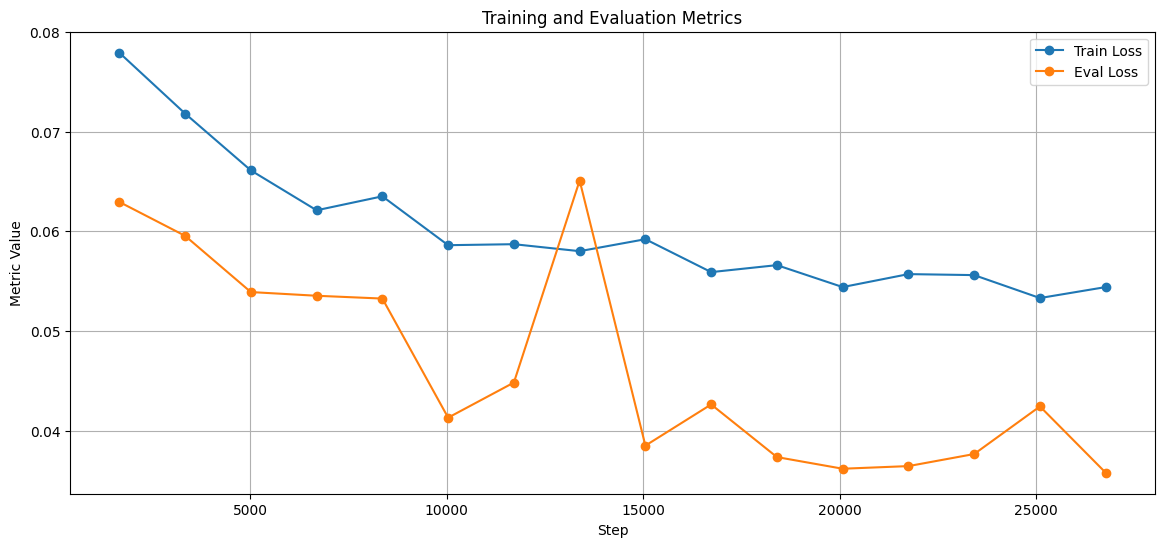

In [69]:
plt.figure(figsize=(14, 6))

# Plot Train Loss
plt.plot(df[df["loss"].notnull()]["step"], df[df["loss"].notnull()]["loss"], label="Train Loss", marker='o')

# Plot Eval Loss
plt.plot(df[df["eval_loss"].notnull()]["step"], df[df["eval_loss"].notnull()]["eval_loss"], label="Eval Loss", marker='o')

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.title("Training and Evaluation Metrics")
plt.legend()
plt.grid()
plt.show()


## Avaliação do Modelo

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert_best_model")
model.to(device)

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

test_dataloader = DataLoader(
    tokenized_test.remove_columns(['title', 'text']),  # remove colunas extras
    batch_size=8,
    collate_fn=collator
)

all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Mande para GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        all_logits.append(logits.cpu())
        if 'labels' in batch:
            all_labels.append(batch['labels'].cpu())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels) if all_labels else None

In [65]:
probabilities = softmax(logits, axis=1)
positive_class_probs = probabilities[:, 1]

# Métricas probabilísticas
auc = np.round(roc_auc_score(labels, positive_class_probs), 3)

# Classe prevista
predicted_classes = np.argmax(probabilities, axis=1)

# Métricas de classe
acc = np.round(accuracy_score(labels, predicted_classes), 3)
precision = np.round(precision_score(labels, predicted_classes, average="binary"), 3)
recall = np.round(recall_score(labels, predicted_classes, average="binary"), 3)
f1 = np.round(f1_score(labels, predicted_classes, average="binary"), 3)

In [66]:
# Cria DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"],
    "Value": [acc, precision, recall, f1, auc]
})

# Exibe de forma bonita
display(metrics_df)

,Metric,Value
0,Accuracy,0.991
1,Precision,0.989
2,Recall,0.990
3,F1-Score,0.990
4,ROC AUC,0.999


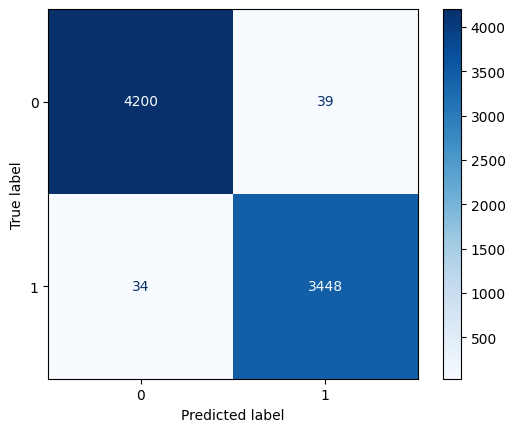

In [67]:
cm = confusion_matrix(labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap="Blues")
plt.show()


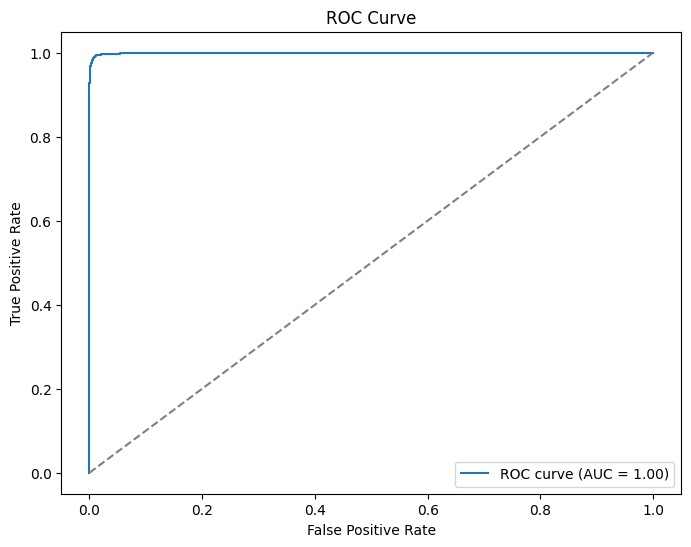

In [ ]:
# ROC e AUC
fpr, tpr, _ = roc_curve(labels, positive_class_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Referências

EDA no dataset ISOT: https://www.kaggle.com/code/nguyenhonganh888/fake-news-detection-a#Explore-Text

Treinamento do BERT: https://github.com/ShawhinT/YouTube-Blog/blob/main/LLMs/model-compression/0_train-teacher.ipynb

Otimização de hiperparâmetros com Optuna: https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8